In [1]:
import os, glob, warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.inspection import permutation_importance

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [2]:
# Load the dataset
df = pd.read_csv('/content/covertype.csv')

In [3]:
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
print(df.head())

print("\nDataset info:")
print(df.info())

print("\nSummary statistics:")
print(df.describe())

print("\nChecking for missing values:")
print(df.isnull().sum())

Dataset shape: (24193, 55)

First few rows:
   Unnamed: 0  Unnamed: 1  Unnamed: 2  Elevation  Aspect  Slope  \
0        2596          51           3        258       0    510   
1        2590          56           2        212      -6    390   
2        2804         139           9        268      65   3180   
3        2785         155          18        242     118   3090   
4        2595          45           2        153      -1    391   

   Horizontal_Distance_To_Hydrology  Vertical_Distance_To_Hydrology  \
0                               221                             232   
1                               220                             235   
2                               234                             238   
3                               238                             238   
4                               220                             234   

   Horizontal_Distance_To_Roadways  Hillshade_9am  ...  Soil_Type32  \
0                              148           6279  ... 

In [4]:
# DATA PREPROCESSING
# =============================================================================
print("\nPreprocessing data...")

# Check if target variable is categorical and encode if needed
# Assuming the target variable is the last column named 'Cover_Type'
target_col = df.columns[-1]


Preprocessing data...


In [5]:
# Check if target needs encoding
if df[target_col].dtype == 'object':
    le = LabelEncoder()
    df[target_col] = le.fit_transform(df[target_col])
    print(f"Target variable encoded. Classes: {le.classes_}")

In [6]:
# Separate features and target
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

print(f"Features shape: {X.shape}, Target shape: {y.shape}")

Features shape: (24193, 54), Target shape: (24193,)


In [7]:
# Check for categorical features and handle them
categorical_cols = X.select_dtypes(include=['object']).columns
if len(categorical_cols) > 0:
    print(f"Categorical features found: {list(categorical_cols)}")
    # One-hot encode categorical features
    X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
    print(f"Features shape after encoding: {X.shape}")


In [10]:
# Split the data
# Handle missing values in y before splitting
df_cleaned = df.dropna(subset=[target_col])
X = df_cleaned.iloc[:, :-1]
y = df_cleaned.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train set: {X_train.shape}, Test set: {X_test.shape}")

Train set: (19353, 54), Test set: (4839, 54)


In [11]:
from sklearn.preprocessing import StandardScaler
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
# MODEL TRAINING AND EVALUATION
# =============================================================================
print("\nTraining and evaluating models...")

# Initialize models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'),
    'Logistic Regression': LogisticRegression(multi_class='ovr', random_state=42, max_iter=1000),
    'SVM': SVC(kernel='rbf', random_state=42, probability=True)
}


Training and evaluating models...


In [13]:
# Train and evaluate each model
results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")

    # Use scaled data for linear models, original for tree-based
    if name in ['Logistic Regression', 'SVM']:
        X_tr, X_te = X_train_scaled, X_test_scaled
    else:
        X_tr, X_te = X_train, X_test

    # Train model
    # Adjust target variable for XGBoost if necessary
    if name == 'XGBoost':
        model.fit(X_tr, y_train - 1)  # Subtract 1 to make it zero-indexed
    else:
        model.fit(X_tr, y_train)

    # Make predictions
    y_pred = model.predict(X_te)

    # Adjust predictions back for XGBoost if necessary
    if name == 'XGBoost':
        y_pred += 1

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Cross-validation score
    # Adjust target variable for XGBoost during cross-validation
    if name == 'XGBoost':
        cv_scores = cross_val_score(model, X_tr, y_train - 1, cv=5, scoring='accuracy')
    else:
        cv_scores = cross_val_score(model, X_tr, y_train, cv=5, scoring='accuracy')

    # Store results
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std()
    }

    print(f"{name} Accuracy: {accuracy:.4f}")
    print(f"{name} CV Accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

    # Classification report
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))


Training Random Forest...
Random Forest Accuracy: 0.9006
Random Forest CV Accuracy: 0.8907 (±0.0051)

Random Forest Classification Report:
              precision    recall  f1-score   support

         1.0       0.86      0.80      0.83       738
         2.0       0.92      0.93      0.92      1894
         3.0       0.87      0.81      0.84       432
         4.0       0.92      0.97      0.95       432
         5.0       0.89      0.93      0.91       479
         6.0       0.85      0.88      0.86       432
         7.0       0.95      0.97      0.96       432

    accuracy                           0.90      4839
   macro avg       0.89      0.90      0.90      4839
weighted avg       0.90      0.90      0.90      4839


Training XGBoost...
XGBoost Accuracy: 0.8956
XGBoost CV Accuracy: 0.8901 (±0.0051)

XGBoost Classification Report:
              precision    recall  f1-score   support

         1.0       0.84      0.80      0.82       738
         2.0       0.92      0.91     

In [16]:
# Tune Random Forest
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

rf = RandomForestClassifier(random_state=42)
grid_rf = GridSearchCV(rf, param_grid_rf, cv=3, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train, y_train)

print(f"Best Random Forest parameters: {grid_rf.best_params_}")
print(f"Best Random Forest CV accuracy: {grid_rf.best_score_:.4f}")

# Tune XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.1, 0.01]
}

xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
grid_xgb = GridSearchCV(xgb, param_grid_xgb, cv=3, scoring='accuracy', n_jobs=-1)
grid_xgb.fit(X_train, y_train - 1) # Subtract 1 here

print(f"Best XGBoost parameters: {grid_xgb.best_params_}")
print(f"Best XGBoost CV accuracy: {grid_xgb.best_score_:.4f}")

# Update models with tuned versions
results['Random Forest Tuned'] = {
    'model': grid_rf.best_estimator_,
    'accuracy': accuracy_score(y_test, grid_rf.best_estimator_.predict(X_test)),
    'cv_mean': grid_rf.best_score_,
    'cv_std': 0  # Not calculated for simplicity
}

# Predict with tuned XGBoost and adjust predictions back
y_pred_xgb_tuned = grid_xgb.best_estimator_.predict(X_test) + 1

results['XGBoost Tuned'] = {
    'model': grid_xgb.best_estimator_,
    'accuracy': accuracy_score(y_test, y_pred_xgb_tuned),
    'cv_mean': grid_xgb.best_score_,
    'cv_std': 0  # Not calculated for simplicity
}

Best Random Forest parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best Random Forest CV accuracy: 0.8848
Best XGBoost parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}
Best XGBoost CV accuracy: 0.8764


In [17]:
# Create comparison dataframe
comparison = pd.DataFrame({
    'Model': [name for name in results.keys()],
    'Test Accuracy': [results[name]['accuracy'] for name in results.keys()],
    'CV Accuracy': [results[name]['cv_mean'] for name in results.keys()]
})

print("\nModel Comparison:")
print(comparison.sort_values('Test Accuracy', ascending=False))


Model Comparison:
                 Model  Test Accuracy  CV Accuracy
4  Random Forest Tuned       0.902253     0.884824
0        Random Forest       0.900599     0.890662
1              XGBoost       0.895640     0.890146
5        XGBoost Tuned       0.886753     0.876402
3                  SVM       0.774334     0.770474
2  Logistic Regression       0.716057     0.717098


In [18]:
# 1. Confusion Matrix for the best model
best_model_name = max(results, key=lambda x: results[x]['accuracy'])
best_model = results[best_model_name]['model']

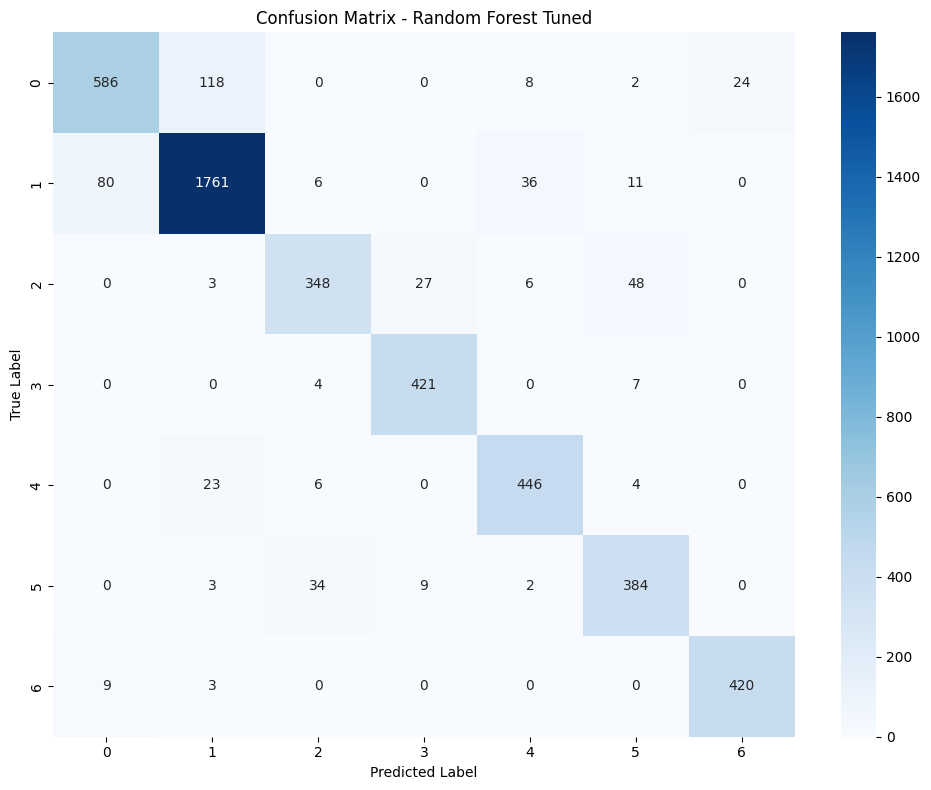

In [21]:
# Use appropriate data format based on model type
if best_model_name in ['Logistic Regression', 'SVM']:
    X_te_vis = X_test_scaled
else:
    X_te_vis = X_test

y_pred_best = best_model.predict(X_te_vis)

import seaborn as sns
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

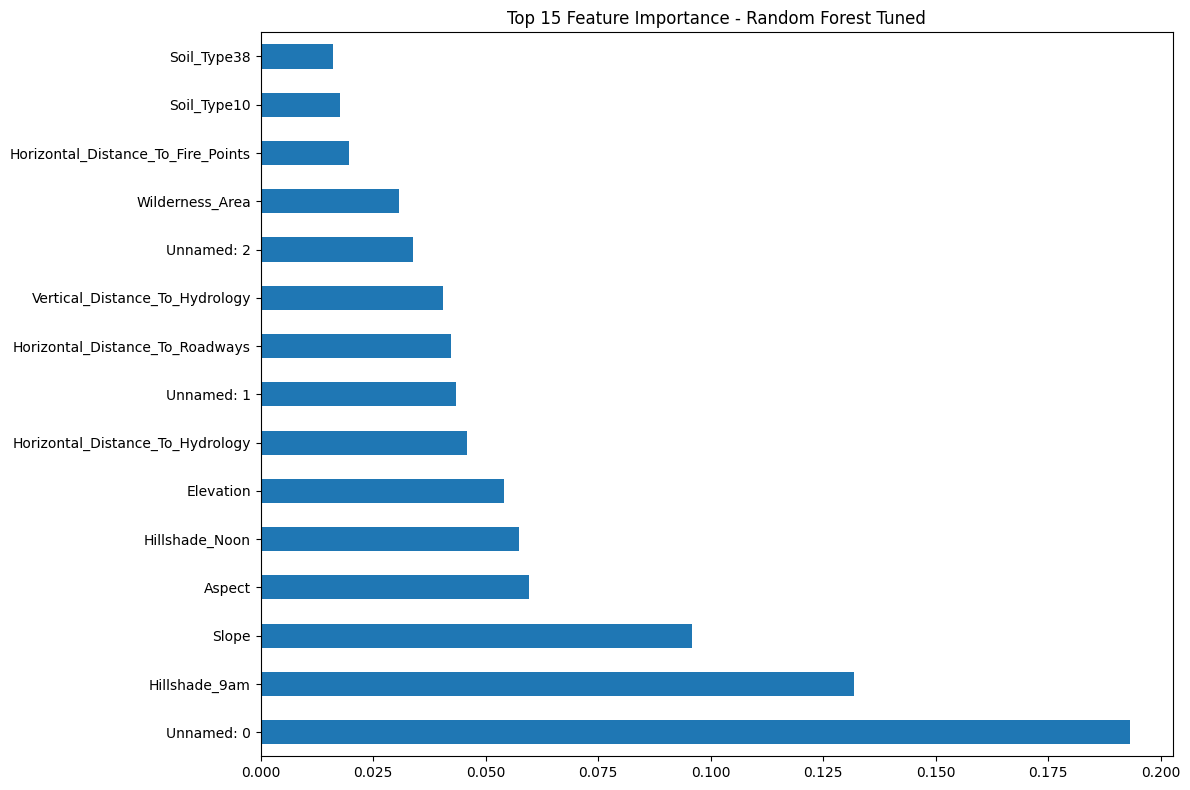

In [22]:
# 2. Feature Importance for tree-based models
if hasattr(best_model, 'feature_importances_'):
    plt.figure(figsize=(12, 8))
    feature_importance = pd.Series(best_model.feature_importances_, index=X.columns)
    feature_importance.nlargest(15).plot(kind='barh')
    plt.title(f'Top 15 Feature Importance - {best_model_name}')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.show()

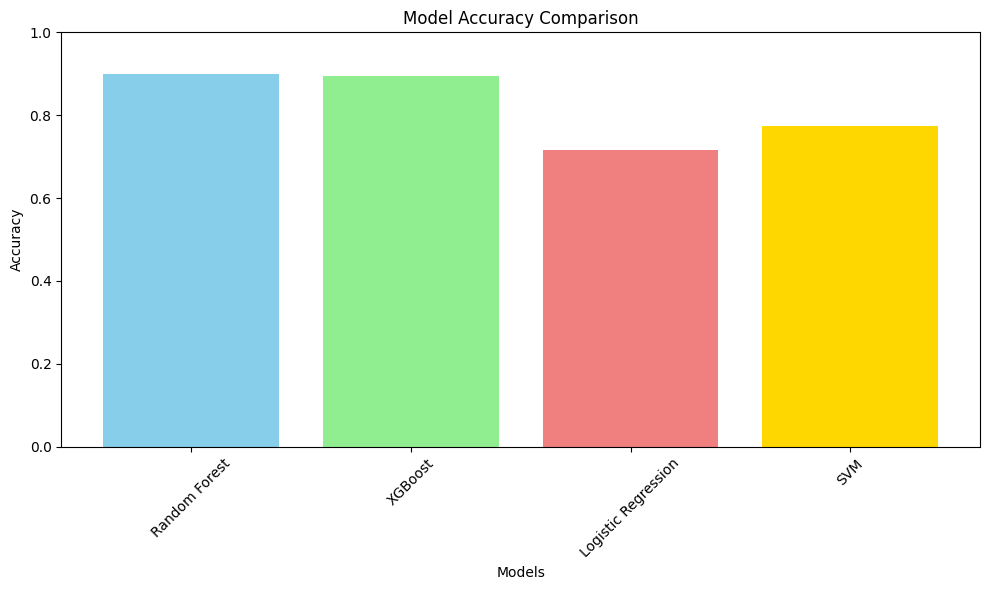

In [23]:
# 3. Model Comparison Plot
plt.figure(figsize=(10, 6))
models_to_plot = [name for name in results.keys() if 'Tuned' not in name]
accuracies = [results[name]['accuracy'] for name in models_to_plot]

plt.bar(models_to_plot, accuracies, color=['skyblue', 'lightgreen', 'lightcoral', 'gold'])
plt.title('Model Accuracy Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('model_comparison.png')
plt.show()

In [24]:
print("\n" + "="*50)
print("FINAL RESULTS")
print("="*50)

# Find the best model
best_model_name = max(results, key=lambda x: results[x]['accuracy'])
best_accuracy = results[best_model_name]['accuracy']

print(f"Best Model: {best_model_name}")
print(f"Best Accuracy: {best_accuracy:.4f}")

print("\nAll Models Performance:")
for name, res in results.items():
    print(f"{name}: Accuracy = {res['accuracy']:.4f}, CV Score = {res['cv_mean']:.4f}")

print("\nAnalysis complete! Check the generated visualizations.")


FINAL RESULTS
Best Model: Random Forest Tuned
Best Accuracy: 0.9023

All Models Performance:
Random Forest: Accuracy = 0.9006, CV Score = 0.8907
XGBoost: Accuracy = 0.8956, CV Score = 0.8901
Logistic Regression: Accuracy = 0.7161, CV Score = 0.7171
SVM: Accuracy = 0.7743, CV Score = 0.7705
Random Forest Tuned: Accuracy = 0.9023, CV Score = 0.8848
XGBoost Tuned: Accuracy = 0.8868, CV Score = 0.8764

Analysis complete! Check the generated visualizations.
